# This notebook was succesfully run with:
- ubuntu 18.04 
- python 3.7.5, tensorflow 1.15, keras 2.2.4, DeepChem 2.3.0
- GPU: Nvidia RTX 2060 
- CPU: AMD Ryzen 3700x

# Description
    
    For a given sprint, ~1000 molecules will be simulated in random order. After simulating say 20-80% of all that 
        sprint's compounds, what if you could simulate the remaining compounds in the order of most likely to have 
        a good simulation result? This notebook attempts to use models to predict the energies of molecules.
    
    The training data is the first 80% of a sprint's runs (for example, runs 1-800). The testing data is the 
        final 20% of runs (for example, runs 801-1000).
    
    Further, but not investigated here, it would be interesting to see if there is any predictive ability of using 
        compounds from previous weeks as the training data and ALL of the next sprint's compounds as the testing 
        data. If that works, then you could predict all of the compounds of the next sprint from the beginning of 
        that sprint. Otherwise, you'd have to sacrifice the first X% as randomly-ordered training data to rank 
        the final (100-X)% as mentioned in the 1st paragraph above.

##   :::Steps:::

    1 - You need to copy & paste the info from a Folding@Home sprint dashboard into a text editor. Or, use the 
        actual CSV file if you have access to it. I'll try to include the CSV file along with this notebook.
        # For example, here's a link to the Dashboard for sprint 4: 
        https://fah-ws3.s3.amazonaws.com/covid-moonshot/sprints/sprint-4/2020-09-06-ugi-tBu-x3110-3v3m-2020-04-Jacobs/index.html

    2 - For that data, make these the columns & column names: 
        'Rank', 'Run', 'Molecule', 'smiles', 'raw_label'
        
    3 - Use that file as the input for this notebook.

# Setup the paths to the datafile and to an export location

In [1]:
# insert the full path of the data file here. I'll try to include it as an upload with this notebook.
data_file = '/FAH_results_s4.csv'

# insert the full path to a folder where the this notebook can save training data
export_location='/.../{some_directory}'

# Import some things

In [2]:
# this first statement widens the notebook window (improves usage of the 
#     window real estate when using a maximized window). It's good for viewing wide matplotlib graphs.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '6'
import sys
print("Python version: " + sys.version)
# Make sure Python version >= 3.6 is being used:
if sys.version_info < (3,6):
    print("I recommend using Python 3.6 or higher. You are using Python "\
           + f"{sys.version_info[0]}.{sys.version_info[1]}")


# import some ordinary things
import time
import numpy as np
import matplotlib.pyplot as plt
import re
import gc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.preprocessing as skpre

# import some extra-ordinary things
from rdkit import Chem
import deepchem as dc
from deepchem.models.graph_models import GraphConvModel
from deepchem.feat import ConvMolFeaturizer, WeaveFeaturizer, CircularFingerprint
from deepchem.feat import AdjacencyFingerprint, RDKitDescriptors
from deepchem.feat import BPSymmetryFunctionInput, CoulombMatrix, CoulombMatrixEig
from deepchem.utils import conformers
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
from deepchem.feat.mol_graphs import ConvMol
from deepchem.metrics import to_one_hot
from deepchem.data.datasets import NumpyDataset
print("DeepChem version: ", dc.__version__)


import keras
from keras.layers import Dense, Activation, Dropout, Flatten, \
                        BatchNormalization, Conv1D, Input, merge, \
                        Reshape, Softmax
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
print("Keras version: " + keras.__version__)


import tensorflow as tf
print("Tensorflow version " + tf.__version__)
# These settings will keep tf GPU memory usage from getting out of control... I think?
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.config.optimizer.set_jit(True) # Enable XLA.
session = tf.Session(config=config)

# random seed
np.random.seed(0)

Python version: 3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]


/home/notyou/anaconda3/envs/keras-tf/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

DeepChem version:  2.3.0
Keras version: 2.2.4
Tensorflow version 1.15.0


Using TensorFlow backend.


# Define functions

In [5]:
def make_clean_labels(data_file=None):
    
    '''
    1) This function expects an input file containing a column for the raw energy values named 'raw_label'. 
       The data comes from the Folding@Home weekly sprint dashboard. Here is an example of such a dashboard:
       https://fah-ws3.s3.amazonaws.com/covid-moonshot/sprints/sprint-4/2020-09-06-ugi-tBu-x3110-3v3m-2020-04-Jacobs/index.html
    2) This function will clean the raw_label energy values by removing the '+/-' info.
    3) The cleaned energy values will be inserted into the same input file in a new column named 'label'.
    '''

    # Load the data file into a Pandas dataframe
    df = pd.read_csv(data_file)

    # Clean the data 
    ## Replace '−' with '-'
    df['raw_label']=df['raw_label'].str.replace('−', '-')
    
    ## Get rid of the "+/-" symbols in the energy columns.
    cleaned_labels = np.array([re.search("[^\s]{1,}", this_row)[0] 
                               for this_row in df['raw_label'].values])

    # add the cleaned labels to the original file as a new column named 'label'
    df['label']=cleaned_labels.astype('float16')
    df.to_csv(data_file, index=False)
    
    # For a quick look, print some data
    print(df.head())

    return f"Cleaned data has been added to the 'label' column in the file {data_file}"


def make_training_data(
                        data_file=None,
                        export_location=None,
                        label_column='label',
                        smiles_column="smiles",
                        featurizer=dc.feat.AdjacencyFingerprint(),
                        test_size=0.2, 
                        cutoff=1.5
                      ):
    
    '''
    data_file is the full path to the datafile that contains the inputs & cleaned labels
    
    export_location should be the path to a directory where this function will automatically save the training data.
    
    label_column is the name of the datafile column containing the cleaned labels
    
    smiles_column is the name of the datafile column containing the smiles name of the input molecules
    
    featurizer is the type of feature generator to use. Here are some examples of featurizers for the featurizer argument:
    
        dc.feat.AdjacencyFingerprint()
        dc.feat.CircularFingerprint()
        RDKitDescriptors()
    
    test_size is the percentage of data that should be allocated as testing data. For example, 0.2 = 20%
    
    cutoff is the threshold for classifying ∆∆G as 0 or 1.
        0: above the threshold ("not interesting")
        1: below the threshold ("interesting")
    '''
    
    print("Using descriptor: " + str(type(featurizer)))
    loader = dc.data.CSVLoader([label_column], smiles_field=smiles_column,
                                   featurizer=featurizer)
    dataset = loader.featurize(
                               data_file,
                               export_location
                              )

    x_train, x_test, y_train, y_test = train_test_split(
        dataset.X, dataset.y, test_size=test_size, random_state=42)
    print("Length of training data, testing data: ", len(x_train), len(x_test))

    # Create additional labels for binary classification
    cutoff = cutoff     #or try cutoff = np.median(y_train)
    y_train_c = (y_train<cutoff).astype(int)
    y_test_c = (y_test<cutoff).astype(int)
    
    if type(featurizer) == dc.feat.basic.RDKitDescriptors:
        # Choose a scaler - either StandardScaler() or MinMaxScaler()
        # scaler = skpre.StandardScaler()
        scaler = skpre.MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
    elif type(featurizer) == dc.feat.adjacency_fingerprints.AdjacencyFingerprint:
        for i in range(len(x_train)):
            x_train[i]=np.array(np.hstack(x_train[i]).flatten())#.reshape(-1, 1)
        for i in range(len(x_test)):
            x_test[i]=np.array(np.hstack(x_test[i]).flatten())#.reshape(-1, 1)
        x_train=np.vstack(x_train)
        x_test=np.vstack(x_test)

    return x_train, y_train, y_train_c, x_test, y_test, y_test_c


def create_model(
                x_train,
                metric='mean_squared_error',
                lr=1e-3,
                k_init = 'he_normal', 
                act = 'relu',
                data_format="channels_last",
                hidden_nodes=1024, 
                dropout=0.2
                ):
    
    ######
    # Input layer
    ######
    input_layer = Input(shape=x_train.shape[1:])
    print("Input layers created.")

    ########
    # hidden layer(s)
    #######
    hidden1a = Dense(hidden_nodes, activation='relu', 
                    kernel_initializer=k_init)(input_layer)
    hidden1a = BatchNormalization()(hidden1a)
    hidden1a = Dropout(0.5)(hidden1a)
    
    hidden1b = Dense(hidden_nodes, activation='relu', 
                     kernel_initializer=k_init)(hidden1a)
    hidden1b = BatchNormalization()(hidden1b)
    hidden1b = Dropout(0.5)(hidden1b)
    
    hidden1c = Dense(hidden_nodes, activation='relu', 
                     kernel_initializer=k_init)(hidden1b)
    hidden1c = BatchNormalization()(hidden1c)
    hidden1c = Dropout(0.5)(hidden1c)
    
    hidden_layers = merge.concatenate([
                                       hidden1a, 
                                       hidden1b, 
                                       hidden1c
                                      ])
    print("Hidden layers created")

    #####
    # outputs
    #####
    
    if metric in ['mean_squared_error', 'mean_absolute_error']:
        print("Using regressor mode.")
        output = Dense(1, 
                        kernel_initializer=k_init, 
                        name='output1'
                       )(hidden_layers)
        loss = metric
    elif metric in ["binary_accuracy", "accuracy"]:
        print("Using classification mode.")
        output_act = 'sigmoid'
        output = Dense(1, 
                        activation=output_act, 
                        kernel_initializer=k_init, 
                        name='output1'
                       )(hidden_layers)
        loss = "binary_crossentropy"
    print("Outputs created.")

    # setup model
    model = keras.models.Model(inputs=[
                                        input_layer
                                        ], 
                                  outputs=[
                                         output
                                        ])
    opt = keras.optimizers.Adam(lr=lr)
    print("Model setup.")

    # compile the model    
    model.compile(
                     loss=loss,
                     optimizer=opt,
                     metrics=[metric]
                  )
    print("Model compiled.")
    return model


def reset_keras(model):
    
    # This function frees up GPU resources by resetting Keras instance.
    
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as needed
    except:
        pass

    print(gc.collect()) # if it's done something, you should see a number being outputted

    # Use the same config as was used to create the session
    tf.keras.backend.clear_session()
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = .95
    config.gpu_options.visible_device_list = "0"
    tf.config.optimizer.set_jit(True) # Enable XLA.
    set_session(tf.Session(config=config))
    tf.config.optimizer.set_jit(True) # Enable XLA.

# Clean the input datafile

In [18]:
make_clean_labels(data_file)

   Rank  Run          Molecule  \
0   372    3  EN300-26619500_1   
1   222    4  EN300-26619500_2   
2   996    5   EN300-7493272_2   
3   176    6   EN300-7464663_1   
4   107    7   EN300-7464663_2   

                                              smiles  raw_label     label  
0  CC(C)(C)NC(=O)[C@H](c1cccnc1)N(CCc2nc3ncc(cn3n...  1.1 ± 0.3  1.099609  
1  CC(C)(C)NC(=O)[C@@H](c1cccnc1)N(CCc2nc3ncc(cn3...  0.6 ± 0.4  0.600098  
2  CC(C)(C)NC(=O)[C@@H](c1cccnc1)N([C@@H]2C[C@H](...  2.6 ± 0.2  2.599609  
3  CC(C)(C)NC(=O)[C@H](c1cccnc1)N(CC2CC(=C3CCC3)C...  0.5 ± 0.2  0.500000  
4  CC(C)(C)NC(=O)[C@@H](c1cccnc1)N(CC2CC(=C3CCC3)...  0.1 ± 0.2  0.099976  


"Cleaned data has been added to the 'label' column in the file /home/notyou/Downloads/immune/FAH/sprint4/FAH_results_s4_b.csv"

# Create training data

Let's try 3 different versions of the training data. Each is derived from the smiles in the datafile.
<br>x_train_raw1 is based on AdjacencyFingerprint()
<br>x_train_raw2 is based on CircularFingerprint()
<br>x_train_raw3 is based on RDKitDescriptors()
<br>Later in this notebook, I'll try ConvMolFeaturizer(). It requires a different treatment than the 3 above, so I'll try it further down.

In [6]:
x_train_raw1, y_train_r, y_train_c, x_test_raw1, y_test_r, y_test_c = \
                    make_training_data(
                        data_file=data_file, 
                        export_location=export_location,
                        featurizer=dc.feat.AdjacencyFingerprint(),
                        label_column='label'
                        )

x_train_raw2, y_train_r, y_train_c, x_test_raw2, y_test_r, y_test_c = \
                    make_training_data(
                        data_file=data_file, 
                        export_location=export_location,
                        featurizer=dc.feat.CircularFingerprint(),
                        label_column='label'
                        )

x_train_raw3, y_train_r, y_train_c, x_test_raw3, y_test_r, y_test_c = \
                    make_training_data(
                        data_file=data_file, 
                        export_location=export_location,
                        featurizer=RDKitDescriptors(),
                        label_column='label'
                        )

Using descriptor: <class 'deepchem.feat.adjacency_fingerprints.AdjacencyFingerprint'>
Loading raw samples now.
shard_size: 8192
About to start loading CSV from /home/notyou/Downloads/immune/FAH/sprint4/FAH_results_s4_b.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 1.855 s
TIMING: dataset construction took 2.188 s
Loading dataset from disk.
Length of training data, testing data:  1473 369
Using descriptor: <class 'deepchem.feat.fingerprints.CircularFingerprint'>
Loading raw samples now.
shard_size: 8192
About to start loading CSV from /home/notyou/Downloads/immune/FAH/sprint4/FAH_results_s4_b.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 3.076 s
TIMING: dataset construction took 3.149 s
Loading dataset from disk.
Length of training data, testing data:  1473 369
Using descriptor: <class 'deepchem.feat.basic.RDKitDescriptors'>
Loading raw samples now.
shard_s

### Each of those appears to produce a different format, so let's do some processing & reshaping:
- These have been added to the make_training_data() function. I'm presenting them below just for acknowledgementm so they're commented out.

In [81]:
# # AdjacencyFingerprint produces nested arrays of 1s and 0s
# for i in range(len(x_train_raw1)):
#     x_train_raw1[i]=np.array(np.hstack(x_train_raw1[i]).flatten())
# for i in range(len(x_test_raw1)):
#     x_test_raw1[i]=np.array(np.hstack(x_test_raw1[i]).flatten())
# x_train_raw1 = np.vstack(x_train_raw1)
# x_test_raw1 = np.vstack(x_test_raw1)

# # CircularFootprint produces simple arrays of 1s and 0s, so no processing & reshaping needed.

# # RDKit produces floats
# # Choose a scaler - either StandardScaler() or MinMaxScaler()
# # scaler = skpre.StandardScaler()
# scaler = skpre.MinMaxScaler()
# x_train_raw3_scaled = scaler.fit_transform(x_train_raw3)
# x_test_raw3_scaled = scaler.transform(x_test_raw3)

### All of those can be combined to make mega training data if desired.

In [7]:
mega_x_train_raw = np.hstack([x_train_raw3, x_train_raw1, x_train_raw2])
mega_x_test_raw = np.hstack([x_test_raw3, x_test_raw1, x_test_raw2])

# Create & train the model

Input layers created.
Hidden layers created
Using regressor mode.
Outputs created.
Model setup.
Model compiled.
Train on 1473 samples, validate on 369 samples
Epoch 1/350
1473/1473 [==============================] - 9s 6ms/step - loss: 21.0198 - mean_squared_error: 13.8151 - val_loss: 12.1672 - val_mean_squared_error: 12.1672
Epoch 2/350
1473/1473 [==============================] - 0s 119us/step - loss: 20.8779 - mean_squared_error: 14.6156 - val_loss: 12.8939 - val_mean_squared_error: 12.8939
Epoch 3/350
1473/1473 [==============================] - 0s 121us/step - loss: 19.1020 - mean_squared_error: 12.8141 - val_loss: 13.0360 - val_mean_squared_error: 13.0360
Epoch 4/350
1473/1473 [==============================] - 0s 123us/step - loss: 18.3923 - mean_squared_error: 12.7746 - val_loss: 12.1086 - val_mean_squared_error: 12.1086
Epoch 5/350
1473/1473 [==============================] - 0s 124us/step - loss: 17.2735 - mean_squared_error: 11.9444 - val_loss: 11.7075 - val_mean_squared_err

1473/1473 [==============================] - 0s 117us/step - loss: 12.3672 - mean_squared_error: 9.1731 - val_loss: 8.8241 - val_mean_squared_error: 8.8241
Epoch 49/350
1473/1473 [==============================] - 0s 120us/step - loss: 12.4216 - mean_squared_error: 9.1908 - val_loss: 9.1660 - val_mean_squared_error: 9.1660
Epoch 50/350
1473/1473 [==============================] - 0s 117us/step - loss: 12.5997 - mean_squared_error: 9.3921 - val_loss: 9.3058 - val_mean_squared_error: 9.3058
Epoch 51/350
1473/1473 [==============================] - 0s 117us/step - loss: 11.4187 - mean_squared_error: 8.4527 - val_loss: 9.4043 - val_mean_squared_error: 9.4043
Epoch 52/350
1473/1473 [==============================] - 0s 117us/step - loss: 11.3040 - mean_squared_error: 8.2842 - val_loss: 9.6025 - val_mean_squared_error: 9.6025
Epoch 53/350
1473/1473 [==============================] - 0s 122us/step - loss: 12.0913 - mean_squared_error: 8.9980 - val_loss: 9.5624 - val_mean_squared_error: 9.5624

Epoch 97/350
1473/1473 [==============================] - 0s 118us/step - loss: 9.4433 - mean_squared_error: 6.9754 - val_loss: 8.6861 - val_mean_squared_error: 8.6861
Epoch 98/350
1473/1473 [==============================] - 0s 127us/step - loss: 8.6596 - mean_squared_error: 6.4397 - val_loss: 8.2829 - val_mean_squared_error: 8.2829
Epoch 99/350
1473/1473 [==============================] - 0s 122us/step - loss: 10.0396 - mean_squared_error: 7.4255 - val_loss: 7.6437 - val_mean_squared_error: 7.6437
Epoch 100/350
1473/1473 [==============================] - 0s 124us/step - loss: 8.8856 - mean_squared_error: 6.4984 - val_loss: 6.9525 - val_mean_squared_error: 6.9525
Epoch 101/350
1473/1473 [==============================] - 0s 120us/step - loss: 9.4456 - mean_squared_error: 6.8569 - val_loss: 6.4977 - val_mean_squared_error: 6.4977
Epoch 102/350
1473/1473 [==============================] - 0s 124us/step - loss: 9.7328 - mean_squared_error: 7.0069 - val_loss: 6.1820 - val_mean_squared_er

1473/1473 [==============================] - 0s 119us/step - loss: 6.4153 - mean_squared_error: 4.7528 - val_loss: 5.4788 - val_mean_squared_error: 5.4788
Epoch 146/350
1473/1473 [==============================] - 0s 117us/step - loss: 6.8291 - mean_squared_error: 4.9439 - val_loss: 5.4201 - val_mean_squared_error: 5.4201
Epoch 147/350
1473/1473 [==============================] - 0s 120us/step - loss: 7.8713 - mean_squared_error: 5.8687 - val_loss: 5.6147 - val_mean_squared_error: 5.6147
Epoch 148/350
1473/1473 [==============================] - 0s 120us/step - loss: 8.0920 - mean_squared_error: 5.7584 - val_loss: 5.6972 - val_mean_squared_error: 5.6972
Epoch 149/350
1473/1473 [==============================] - 0s 119us/step - loss: 7.4698 - mean_squared_error: 5.7346 - val_loss: 5.8207 - val_mean_squared_error: 5.8207
Epoch 150/350
1473/1473 [==============================] - 0s 120us/step - loss: 6.4412 - mean_squared_error: 4.6666 - val_loss: 5.8994 - val_mean_squared_error: 5.8994


1473/1473 [==============================] - 0s 121us/step - loss: 6.0693 - mean_squared_error: 4.2647 - val_loss: 3.4288 - val_mean_squared_error: 3.4288
Epoch 194/350
1473/1473 [==============================] - 0s 118us/step - loss: 5.8615 - mean_squared_error: 4.1294 - val_loss: 3.5742 - val_mean_squared_error: 3.5742
Epoch 195/350
1473/1473 [==============================] - 0s 119us/step - loss: 6.6085 - mean_squared_error: 4.8672 - val_loss: 3.9101 - val_mean_squared_error: 3.9101
Epoch 196/350
1473/1473 [==============================] - 0s 113us/step - loss: 5.3007 - mean_squared_error: 3.8567 - val_loss: 4.1535 - val_mean_squared_error: 4.1535
Epoch 197/350
1473/1473 [==============================] - 0s 115us/step - loss: 5.4086 - mean_squared_error: 3.9395 - val_loss: 4.3181 - val_mean_squared_error: 4.3181
Epoch 198/350
1473/1473 [==============================] - 0s 114us/step - loss: 5.5944 - mean_squared_error: 3.9853 - val_loss: 4.3865 - val_mean_squared_error: 4.3865


1473/1473 [==============================] - 0s 123us/step - loss: 5.0179 - mean_squared_error: 3.6260 - val_loss: 3.4317 - val_mean_squared_error: 3.4317
Epoch 242/350
1473/1473 [==============================] - 0s 120us/step - loss: 4.4563 - mean_squared_error: 3.1928 - val_loss: 3.4598 - val_mean_squared_error: 3.4598
Epoch 243/350
1473/1473 [==============================] - 0s 123us/step - loss: 5.2219 - mean_squared_error: 3.7816 - val_loss: 3.3780 - val_mean_squared_error: 3.3780
Epoch 244/350
1473/1473 [==============================] - 0s 120us/step - loss: 4.7000 - mean_squared_error: 3.4201 - val_loss: 3.3170 - val_mean_squared_error: 3.3170
Epoch 245/350
1473/1473 [==============================] - 0s 119us/step - loss: 5.4048 - mean_squared_error: 4.0202 - val_loss: 3.3330 - val_mean_squared_error: 3.3330
Epoch 246/350
1473/1473 [==============================] - 0s 117us/step - loss: 4.2687 - mean_squared_error: 3.0830 - val_loss: 3.3585 - val_mean_squared_error: 3.3585


1473/1473 [==============================] - 0s 118us/step - loss: 3.7836 - mean_squared_error: 2.6371 - val_loss: 3.2204 - val_mean_squared_error: 3.2204
Epoch 290/350
1473/1473 [==============================] - 0s 119us/step - loss: 4.3221 - mean_squared_error: 3.1382 - val_loss: 3.1211 - val_mean_squared_error: 3.1211
Epoch 291/350
1473/1473 [==============================] - 0s 117us/step - loss: 4.2977 - mean_squared_error: 3.0691 - val_loss: 3.0371 - val_mean_squared_error: 3.0371
Epoch 292/350
1473/1473 [==============================] - 0s 118us/step - loss: 3.9813 - mean_squared_error: 2.7575 - val_loss: 2.9463 - val_mean_squared_error: 2.9463
Epoch 293/350
1473/1473 [==============================] - 0s 118us/step - loss: 4.4099 - mean_squared_error: 3.1554 - val_loss: 2.8819 - val_mean_squared_error: 2.8819
Epoch 294/350
1473/1473 [==============================] - 0s 116us/step - loss: 4.2128 - mean_squared_error: 3.0289 - val_loss: 2.8698 - val_mean_squared_error: 2.8698


1473/1473 [==============================] - 0s 119us/step - loss: 4.1153 - mean_squared_error: 2.9802 - val_loss: 2.9321 - val_mean_squared_error: 2.9321
Epoch 338/350
1473/1473 [==============================] - 0s 115us/step - loss: 3.7684 - mean_squared_error: 2.7109 - val_loss: 2.9337 - val_mean_squared_error: 2.9337
Epoch 339/350
1473/1473 [==============================] - 0s 119us/step - loss: 3.6010 - mean_squared_error: 2.5880 - val_loss: 2.9152 - val_mean_squared_error: 2.9152
Epoch 340/350
1473/1473 [==============================] - 0s 118us/step - loss: 3.3931 - mean_squared_error: 2.4048 - val_loss: 2.8986 - val_mean_squared_error: 2.8986
Epoch 341/350
1473/1473 [==============================] - 0s 116us/step - loss: 3.5060 - mean_squared_error: 2.4891 - val_loss: 2.8931 - val_mean_squared_error: 2.8931
Epoch 342/350
1473/1473 [==============================] - 0s 119us/step - loss: 4.2223 - mean_squared_error: 2.9778 - val_loss: 2.8521 - val_mean_squared_error: 2.8521


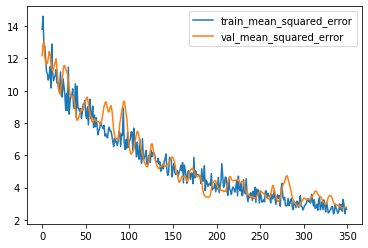

In [69]:
## Choose a model type - classification or regression
#     For regression, metric = "mean_squared_error" or "mean_absolute_error"
#     For classification, metric = "binary_accuracy"

# metric='binary_accuracy'
metric = "mean_squared_error"
# metric = "mean_absolute_error"

batch_size=1024
epochs=350

# Set general variables to hold data. Because of the 
#     if statements throughout below, the training data 
#     should be the only variables that you have to touch.
#     The choices are x_train_raw1, x_train_raw2, x_train_raw3, or mega_x_train_raw 
#     (and likewise for the test variable)
x_train=x_train_raw1
x_test=x_test_raw1

# for classification
if metric=='binary_accuracy':
    y_train=y_train_c
    y_test=y_test_c

# for regression
if metric in ['mean_squared_error', 'mean_absolute_error']:
    y_train=y_train_r
    y_test=y_test_r

model = create_model(x_train, 
                     metric=metric, 
                     hidden_nodes=512,
                     lr=1e-4, 
                     dropout=0.2
                    )


time_start = time.time()
if metric=='binary_accuracy':
    history = model.fit(
                        x_train,
                        y_train,
                        epochs=epochs, 
                        batch_size=batch_size,
                        class_weight = {0: (np.unique(y_train, return_counts=True)[1][1]/np.unique(y_train, return_counts=True)[1][0]),
                                        1: 1.0},
                        validation_data=(
                                        x_test,
                                        y_test, 
                                        ),
                        shuffle = True
                        )
if metric in ['mean_squared_error', 'mean_absolute_error']:
    history = model.fit(
                        x_train,
                        y_train,
                        epochs=epochs, 
                        batch_size=batch_size,
                        # weights created by trial & error. Not much theory here.
                        sample_weight=1.2**np.abs(y_train.flatten()-np.median(y_train.flatten())),
                        validation_data=(
                                    x_test,
                                    y_test, 
                                    ),
                        shuffle = True
                        )
time_end = time.time()
print("Elapsed training time: ", np.round(time_end-time_start, 2))

plt.plot(history.history[metric], label="train_"+metric)
plt.plot(history.history['val_'+metric], label="val_"+metric)
plt.legend(loc='upper right')

if metric == "binary_accuracy":
    print("========TRAIN REPORT=========")
    check_training = model.predict(x_train)
    print(classification_report(y_train, np.round(check_training)))

    print("========TEST REPORT=========")
    check_testing = model.predict(x_test)
    print(classification_report(y_test, np.round(check_testing)))

print("Compare predictions vs truth on lowest train energy values")
print(pd.DataFrame({'predict':model.predict_on_batch(x_train).flatten(), 
              'truth':y_train.flatten()}, 
             index=None).sort_values('truth')[:50])

print("Compare predictions vs truth on highest train energy values")
print(pd.DataFrame({'predict':model.predict_on_batch(x_train).flatten(), 
              'truth':y_train.flatten()}, 
             index=None).sort_values('truth')[-50:])    
    
print("Compare predictions vs truth on lowest test energy values")
print(pd.DataFrame({'predict':model.predict_on_batch(x_test).flatten(), 
              'truth':y_test.flatten()}, 
             index=None).sort_values('truth')[:50])

print("Compare predictions vs truth on highest test energy values")
print(pd.DataFrame({'predict':model.predict_on_batch(x_test).flatten(), 
              'truth':y_test.flatten()}, 
             index=None).sort_values('truth')[-50:])

### Looking at the results^, it appears that there is some predictive ability.

# Next, let's see how a GraphConvModel performs
- I couldn't get this to reliably work. The problem is that everytime the fitting process does an iteration, it consumes more and more GPU memory. Thus, after a small number of loops, my GPU would sometimes crash from memory resource exhaustion.
- Why does GPU usage increase for every iteration?

In [68]:

# Choose a method
mode="classification"
# mode="regression"


# Create the training data for this type of model using the ConvMolFeaturizer().
featurizer=dc.feat.ConvMolFeaturizer()

# 'label' is the datafile column containing that labels.
# 'smiles' is the datafile column containing the smiles.
loader = dc.data.CSVLoader(["label"], smiles_field="smiles",
                                   featurizer=featurizer)

# This creates a dataset from a CSV file. 
# It will also save the formatted data to a folder which is specified 
#     as export_location at the beginning of this notebook
dataset = loader.featurize(
                           data_file,
                           export_location
                          )

# test_size is the percentage of data that should be 
#     allocated as testing data. For example, 20% 
#     should be input as 0.2.
x_train, x_test, y_train, y_test = train_test_split(
    dataset.X, dataset.y, test_size=0.2, random_state=42)

## create training data 
#     _c is the classification version of the labels. 
#         Classify the labels as above or below energy_threshold.
#     _r is the regression version of the labels
#     w are weights
# DeepChem kept giving me errors when using the GraphConvModel() & model.fit(), so I had to type everything as float64 and checked shapes.
exs = x_train
yis = y_train.astype('float64')
energy_threshold = 1.0
# use weights to balance data
w_train_r = 1.1**(np.abs(yis-np.median(yis))+1).astype('float64').reshape(-1, 1)# 1 keeps the weights from equaling 0.
class_ratio = np.unique((yis <= energy_threshold).astype('float64'), return_counts=True)[1][0]/np.unique((yis <= energy_threshold).astype('float64'), return_counts=True)[1][1]
w_train_c = [class_ratio if v == 1.0 else 1 for v in (yis <= energy_threshold).astype('float64') ]

# The GraphConvModel expects data to be organized into the format NumpyDataset(training data, training labels, training weights)
train_data_c = NumpyDataset(exs, (yis <= energy_threshold).astype('float64'), w_train_c)
train_data_r = NumpyDataset(exs, yis, w_train_r)

## create testing data
#     _c is the classification version of the labels. Classify the labels as above or below energy=1.
#     _r is the regression version of the labels
#     w are weights
# DeepChem kept giving me errors when using the GraphConvModel() & model.fit(), so I had to type everything as float64 and checked shapes.
exs = x_test
yis = y_test.astype('float64')
w_test_r = 1.1**(np.abs(yis-np.median(yis))+1).astype('float64').reshape(-1, 1) # 1 keeps the weights from equaling 0.
class_ratio = np.unique((yis <= energy_threshold).astype('float64'), return_counts=True)[1][0]/np.unique((yis <= energy_threshold).astype('float64'), return_counts=True)[1][1]
w_test_c = [class_ratio if v == 1.0 else 1 for v in (yis <= energy_threshold).astype('float64') ]
# The GraphConvModel expects data to be organized into the format NumpyDataset(training data, training labels, training weights)
test_data_c = NumpyDataset(exs, (yis <= energy_threshold).astype('float64'), w_test_c)
test_data_r = NumpyDataset(exs, yis, w_test_r)


## Use transformers. This transformer normalizes the data. 
#      I haven't gotten good results with it, so I commented it out and didn't use it.
# transformer = dc.trans.NormalizationTransformer(transform_w=True, dataset=train_data_r)
# train_data_r = transformer.transform(train_data_r)
# test_data_r = transformer.transform(test_data_r)


## Use the general variables 'train_data' and 'test_data' to hold the training & test data. 
#     That way, if you switch from 'train_data_r' to 'train_data_c', all you have to do is change 
#     the values here instead of having to change ~10+ instances further below.
if mode == "classification":
    train_dataset=train_data_c
    test_dataset=test_data_c
elif mode =="regression":
    train_dataset=train_data_r
    test_dataset=test_data_r
print("Shapes of everything: ", 
      train_dataset.X.shape, train_dataset.y.shape, train_dataset.w.shape, 
      test_dataset.X.shape, test_dataset.y.shape, test_dataset.w.shape)

## Create model
n_tasks = 1 # I think this is "the number of model outputs". Not sure why it's called a "task"

if mode == "classification":
    model = GraphConvModel(n_tasks, 
                           graph_conv_layers=[128, 128],
                           dense_layer_size=64, 
                           batch_size=512, 
                           learning_rate = 1e-3,
                           verbose=True,
                           dropout=.1,
                           mode='classification')
if mode == "regression":
    model = GraphConvModel(n_tasks, 
                       graph_conv_layers=[128, 128],
                       dense_layer_size=64, 
                       batch_size=512, 
                       learning_rate = 1e-4,
                       verbose=True,
                       dropout=.1,
                       mode='regression')

## train the model
# Caution: Sometimes, this loop accumulates GPU memory usafe after every iteration, so I've 
#      only been able to run a limited number of loops before my GPU's memory is exhausted.
#      I got this fitting loop from a tutorial on the DeepChem Github, but, like I said, it makes my GPU crash sometimes:
# https://github.com/deepchem/deepchem/blob/master/examples/tutorials/04_Introduction_to_Graph_Convolutions.ipynb
num_epochs = 50
losses = []
for i in range(num_epochs):
    loss = model.fit(train_dataset, nb_epoch=1)
    print("Epoch %d loss: %f" % (i, loss))
    losses.append(loss)
    
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)    



if mode == "classification":
    print("========TRAIN REPORT=========")
    check_training = model.predict(train_dataset)
    print(classification_report(train_dataset.y, np.argmax(check_training, axis=2).flatten()))

    print("========TEST REPORT=========")
    check_testing = model.predict(test_dataset)
    print(classification_report(test_dataset.y, np.argmax(check_testing, axis=2).flatten()))

elif mode == "regression":
    ## view some results
    print("Compare predictions vs truth on lowest train energy values")
    print(pd.DataFrame({'predict':model.predict(train_dataset).flatten(), 
                  'truth':train_dataset.y.flatten()}, 
                 index=None).sort_values('truth')[:50])

    print("Compare predictions vs truth on highest train energy values")
    print(pd.DataFrame({'predict':model.predict(train_dataset).flatten(), 
                  'truth':y_train.flatten()}, 
                 index=None).sort_values('truth')[-50:])    

    print("Compare predictions vs truth on lowest test energy values")
    print(pd.DataFrame({'predict':model.predict(test_dataset).flatten(), 
                  'truth':test_dataset.y.flatten()}, 
                 index=None).sort_values('truth')[:50])

    print("Compare predictions vs truth on highest test energy values")
    print(pd.DataFrame({'predict':model.predict(test_dataset).flatten(), 
                  'truth':test_dataset.y.flatten()}, 
                 index=None).sort_values('truth')[-50:])

    ## view the metrics 
    model.evaluate(train_dataset, [metric]), model.evaluate(test_dataset, [metric])
    

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /home/notyou/Downloads/immune/FAH/sprint4/FAH_results_s4_b.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 2.982 s
TIMING: dataset construction took 3.524 s
Loading dataset from disk.
Shapes of everything:  (1473,) (1473, 1) (1473,) (369,) (369, 1) (369,)


/home/notyou/anaconda3/envs/keras-tf/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/notyou/anaconda3/envs/keras-tf/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/notyou/anaconda3/envs/keras-tf/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 0 loss: 1.236642
Epoch 1 loss: 1.130948
Epoch 2 loss: 1.098859
Epoch 3 loss: 1.099185
Epoch 4 loss: 1.101441
Epoch 5 loss: 1.099030
Epoch 6 loss: 1.083660
Epoch 7 loss: 1.088529
Epoch 8 loss: 1.082745
Epoch 9 loss: 1.076809
Epoch 10 loss: 1.082947
Epoch 11 loss: 1.078614
Epoch 12 loss: 1.071422
Epoch 13 loss: 1.075248
Epoch 14 loss: 1.075559
Epoch 15 loss: 1.071030
Epoch 16 loss: 1.072183
Epoch 17 loss: 1.073617
Epoch 18 loss: 1.066327
Epoch 19 loss: 1.069438
Epoch 20 loss: 1.055624
Epoch 21 loss: 1.055608
Epoch 22 loss: 1.052165
Epoch 23 loss: 1.051607
Epoch 24 loss: 1.052078
Epoch 25 loss: 1.050725
Epoch 26 loss: 1.053971
Epoch 27 loss: 1.052361
Epoch 28 loss: 1.040203
Epoch 29 loss: 1.036293
Epoch 30 loss: 1.035356
Epoch 31 loss: 1.044992
Epoch 32 loss: 1.046906
Epoch 33 loss: 0.995246
Epoch 34 loss: 1.037047
Epoch 35 loss: 1.041099
Epoch 36 loss: 1.041570
Epoch 37 loss: 1.030818
Epoch 38 loss: 1.025856
Epoch 39 loss: 1.029655
Epoch 40 loss: 1.019763
Epoch 41 loss: 1.008563
Ep

### It looks like the GraphConVModel does a decent job at predicting molecules that will have energies over 1.0 (class 0). 
### Improvements could probably be made by:
- adjusting the model parameters.
- including the target MPro features or pocket features as an input variable